# Tutorial - How to use the axisrules package

Once the package is installed on your machine (see the readme), you can import it.

In [1]:
import axisrules as axis

We will also need these packages in this tutorial:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In the **data/** folder, I've put some data from an *in situ* experiments conducted in Strasbourg, France during the 2017 French presidential election *(Bouveret et al. (2019). Voter Autrement 2017 for the French Presidential Election - The data of the In Situ Experiment. Zenodo. https://doi.org/10.5281/zenodo.3548677)*. Among other questions, the researcher asked the voters what they would have voted with approval voting. They also asked them what they actually voted in the election which enable us to give weight of the voter, in order to obtain the same distribution as the national score for each candidate. The *approval.csv* and *weights.csv* files contain these information. The *voters.csv* file contains informations about the voters, while the *candidates.csv* files contain some informations about the candidates.


In [3]:
approval  = pd.read_csv('data/approval.csv')
weights = pd.read_csv('data/weights.csv', index_col=0)
candidates = pd.read_csv('data/candidates.csv', index_col=0).to_numpy()

We need to do some preprocessing of the data (because not all of the voters tried the approval voting method)

In [4]:

id_app = approval.to_numpy()[:,0] # The id of the voters who tried the approval method
approval = approval.to_numpy()[:,1:] # The approval ballots 

# We compute the array of weights for the voters that tried the approval method
w = []
for i in range(len(id_app)):
    if id_app[i] in weights.index:
        w.append(weights["approval"][id_app[i]])
    else:
        w.append(0)
w = np.array(w)

# We also save the list of candidates names
cands_name = [candidates[i][0] for i in range(len(candidates))]

This dataset contains 1071 voters and 11 candidates, whose names are printed below:

In [5]:
print(approval.shape)
print(cands_name)

(1071, 11)
['Nicolas Dupont-Aignan', 'Marine Le Pen', 'Emmanuel Macron', 'Benoît Hamon', 'Nathalie Arthaud', 'Philippe Poutou', 'Jacques Cheminade', 'Jean Lassalle', 'Jean-Luc Mélenchon', 'François Asselineau', 'François Fillon']


We can look at the distribution of the number of approved candidates per voter

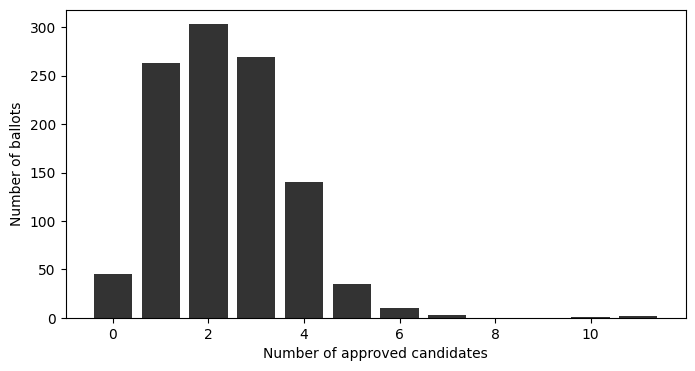

In [6]:
nb_approved = [len([ballot for ballot in approval if sum(ballot) == j]) for j in range(0,12)]
plt.figure(figsize=(8,4))
plt.bar(range(0,12), nb_approved, color="k", alpha=0.8)
plt.xlabel("Number of approved candidates")
plt.ylabel("Number of ballots")
plt.show()

We see that most candidates approved between 1 and 4 candidates. Note that voters that approved 0, 1, or all candidates fit in every axis.

We can compute the scores of every candidate:

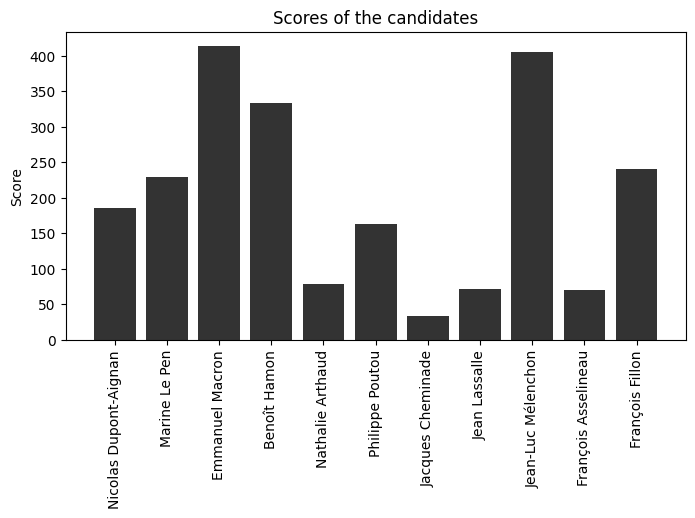

In [7]:
scores = axis.compute_scores(approval, w)
plt.figure(figsize=(8,4))
plt.bar(range(len(scores)), scores, color="k", alpha=0.8)
plt.xticks(range(len(scores)), cands_name, rotation=90)
plt.ylabel("Score")
plt.title("Scores of the candidates")
plt.show()


For the sake of running time, we drop in this tutorial the 3 least approved candidates.

In [8]:
saved = np.argsort(scores)[3:]
cands_name = [cands_name[i] for i in saved]
approval = approval[:,saved]
scores = scores[saved]

We can plot again the distribution of the number of candidates approved per voters : 

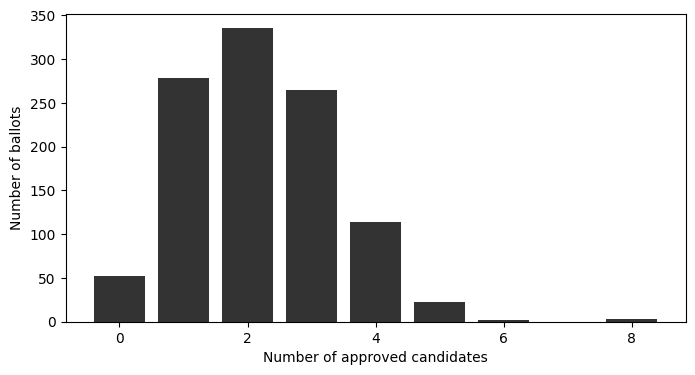

In [9]:
nb_approved = [len([ballot for ballot in approval if sum(ballot) == j]) for j in range(0,9)]
plt.figure(figsize=(8,4))
plt.bar(range(0,9), nb_approved, color="k", alpha=0.8)
plt.xlabel("Number of approved candidates")
plt.ylabel("Number of ballots")
plt.show()

Let's now having fun with our *axisrules* package. Let's start with the Voter Deletion Rule

In [10]:
voter_deletion = axis.VoterDeletion(approval, w)

The most natural thing we want to do is to compute the best axis

In [11]:
best_axis = voter_deletion()
axis.print_axis(best_axis, cands_name)

Nathalie Arthaud < Philippe Poutou < Jean-Luc Mélenchon < Benoît Hamon < Emmanuel Macron < François Fillon < Nicolas Dupont-Aignan < Marine Le Pen


If you know french politics, you'll notice this axis makes a lot of sense.

Let's what's the score of this axis.

In [12]:
score_axis = voter_deletion.get_score(best_axis)
print("Number of voters to delete : ", score_axis)
print("Total number of voters : ", approval.shape[0])
print("Voters with at least 2 approved candidates : ", np.sum(np.sum(approval, axis=1) >= 2))

Number of voters to delete :  256.5306010807114
Total number of voters :  1071
Voters with at least 2 approved candidates :  741


And it seems that most voters fits this axis, even when considering only voters with at least 2 approved candidates.

Note that if you have gurobipy and a Gurobi license, you can run *voter_deletion(solver="lp")* and it will use the LP solver instead of forcebrute. This can be useful when the number of candidates increases.

Let's see what axis we obtain with other axis rules.

In [13]:
axis_rules = [axis.VoterDeletion, axis.MinimalFlips, axis.BallotCompletion, axis.MinimalSwaps, axis.ForbiddenTriples]

for rule in axis_rules:
    print(rule.name)
    rule_instance = rule(approval, w)
    best_axis = rule_instance()
    axis.print_axis(best_axis, cands_name)
    axis_score = rule_instance.get_score(best_axis)
    print("Score of this axis :", axis_score)
    print("\n")

Voter Deletion
Nathalie Arthaud < Philippe Poutou < Jean-Luc Mélenchon < Benoît Hamon < Emmanuel Macron < François Fillon < Nicolas Dupont-Aignan < Marine Le Pen
Score of this axis : 256.5306010807114


Minimal Flips
Nathalie Arthaud < Philippe Poutou < Jean-Luc Mélenchon < Benoît Hamon < Emmanuel Macron < François Fillon < Marine Le Pen < Nicolas Dupont-Aignan
Score of this axis : 403.40488482216153


Ballot Completion
Nathalie Arthaud < Philippe Poutou < Benoît Hamon < Jean-Luc Mélenchon < Emmanuel Macron < François Fillon < Marine Le Pen < Nicolas Dupont-Aignan
Score of this axis : 533.5551611129569


Minimal Swaps
Nathalie Arthaud < Philippe Poutou < Benoît Hamon < Jean-Luc Mélenchon < Emmanuel Macron < François Fillon < Marine Le Pen < Nicolas Dupont-Aignan
Score of this axis : 558.3959134111786


Forbidden Triples
Nathalie Arthaud < Philippe Poutou < Benoît Hamon < Jean-Luc Mélenchon < Emmanuel Macron < François Fillon < Nicolas Dupont-Aignan < Marine Le Pen
Score of this axis : 

Note that we find the inequality described in the paper : *VD < BC < MF < MS < FT*. 

We let the voter explore our other notebooks and the library for the other rules.